
# CIFAR-10 Image Classification + Real-time Webcam Prediction
Welcome to the CIFAR-10 computer vision project! This notebook trains a CNN to classify images from the CIFAR-10 dataset and performs real-time prediction using your webcam.

**Dataset**: 60,000 32x32 color images in 10 classes  
**Goal**: Build a model and use it for live classification via webcam.


In [2]:

# !pip install tensorflow opencv-python matplotlib seaborn scikit-learn pillow

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')


In [3]:

# Set seed for reproducibility(important for unbiased results)
np.random.seed(42)
tf.random.set_seed(42)

# Loading CIFAR-10, already divided into training and testing sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Normalize pixel values to [0, 1] for better training
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Convert labels to categorical (one-hot encoding)
y_train_cat = keras.utils.to_categorical(y_train, 10)
y_test_cat = keras.utils.to_categorical(y_test, 10)

# Class names
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']


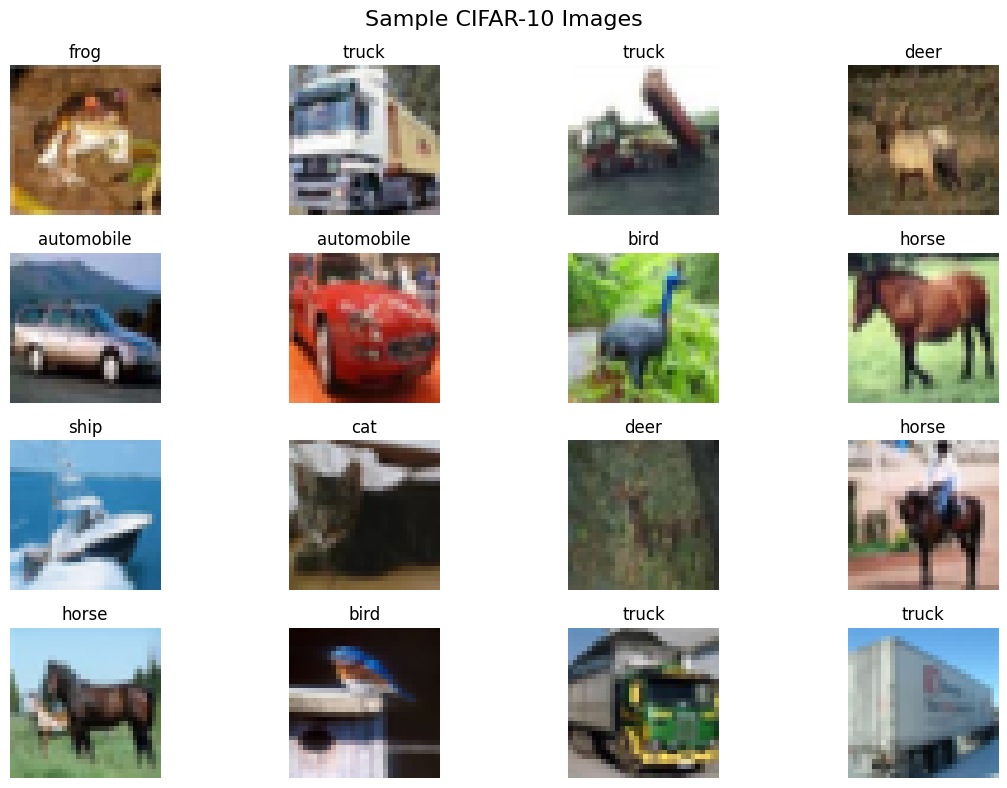

In [4]:

plt.figure(figsize=(12, 8))  # 12 inches wide and 8 inches tall
for i in range(16):
    plt.subplot(4, 4, i+1) # Indices in Matplotlib start from 1
    plt.imshow(x_train[i]) 
    plt.title(class_names[int(y_train[i])]) # Use int() to convert label to integer (as might be inside a 1-element array)
    plt.axis('off') # Hide axes ticks and labels (like 0, 10, 20 pixels)
plt.suptitle("Sample CIFAR-10 Images", fontsize=16) # Adds a Super-title for the entire figure
plt.tight_layout() # Adjusts the layout to prevent overlap
plt.show()


In [6]:

model = keras.Sequential([              # Initializing linear stack of layers and assigning to the variable model
    
    # no. of filters, filter size, activation function, input shape   
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 3)), 
    layers.BatchNormalization(), # Normalization of activation helps in faster convergence
    layers.Conv2D(32, (3,3), activation='relu'), # Stacks more complexity
    layers.MaxPooling2D((2,2)),   # Reduces computational load by downsampling the feature maps
    layers.Dropout(0.25),  # Randomly sets 25% of the input units to 0 to prevent overfitting
    
    layers.Conv2D(64, (3,3), activation='relu'), # Relu introduces non-linearity
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Flatten(),  # Flattens the input, converting it from 2D to 1D
    layers.Dense(512, activation='relu'), # Fully connected layer with 512 neurons
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax') # Output layer with 10 neurons and probability distribution (softmax) for multi-class classification
])

model.compile(optimizer=keras.optimizers.Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])

model.summary() 


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 737,834 (2.81 MB)

 Trainable params: 736,362 (2.81 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [ ]:
# Data augmentation to improve model generalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

datagen = ImageDataGenerator(
    rotation_range=15, # Randomly rotate upto 15 degrees
    width_shift_range=0.1,  # Randomly shift images horizontally by 10%
    height_shift_range=0.1,   # Randomly shift images vertically by 10%
    horizontal_flip=True,     # Randomly flip images horizontally
    #brightness_range=[0.8, 1.2], # Randomly adjust brightness
    #shear_range=0.1,         # Randomly shear images by 10%
    zoom_range=0.1            # Randomly zoom in on images by 10%
)
datagen.fit(x_train) # Explains how to apply the augmentation to the training data

callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True), # Stops training if no improvement in validation loss for 5 epochs
    keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-4) # Reduces learning rate by half if no improvement in validation loss for 3 epochs but not below 0.0001
]

history = model.fit(
    datagen.flow(x_train, y_train_cat, batch_size=32),
    epochs=50,
    validation_data=(x_test, y_test_cat),
    callbacks=callbacks
)


Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 154s 91ms/step - accuracy: 0.3006 - loss: 2.2374 - top_k_categorical_accuracy: 0.8096 - val_accuracy: 0.4425 - val_loss: 1.5660 - val_top_k_categorical_accuracy: 0.9170 - learning_rate: 0.0010
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 188s 120ms/step - accuracy: 0.4926 - loss: 1.4112 - top_k_categorical_accuracy: 0.9277 - val_accuracy: 0.5134 - val_loss: 1.4914 - val_top_k_categorical_accuracy: 0.9408 - learning_rate: 0.0010
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 163s 104ms/step - accuracy: 0.5638 - loss: 1.2225 - top_k_categorical_accuracy: 0.9495 - val_accuracy: 0.5701 - val_loss: 1.3095 - val_top_k_categorical_accuracy: 0.9491 - learning_rate: 0.0010
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 180s 115ms/step - accuracy: 0.6099 - loss: 1.0953 - top_k_categorical_accuracy: 0.9605 - val_accuracy: 0.5788 - val_loss: 1.2991 - val_top_k_categorical_accuracy: 0.9436 - learning_rate: 0.0010
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 197s 126ms/step

In [7]:

# Evaluate the model on the test set and get loss, accuracy, and top-k accuracy
test_loss, test_acc, top_k = model.evaluate(x_test, y_test_cat, verbose=0) # verbose=0 means no output during evaluation
# The order of returned metrics matches in model.compile()
print(f"Test Accuracy: {test_acc:.4f}") # Print test accuracy up to 4 decimal places
print(f"Top-K Accuracy: {top_k:.4f}")
print(f"Test Loss: {test_loss:.4f}") # Print test loss up to 4 decimal places

# Classification Report
y_pred = model.predict(x_test) # Generates predicted probabilities for each class for every test image.
y_pred_classes = np.argmax(y_pred, axis=1) # Convert predicted probabilities to class labels.
# Argmax returns the index of the maximum value along the specified axis (axis=1 means across columns).
y_true_classes = np.argmax(y_test_cat, axis=1) # Converts the true one-hot encoded labels into their original class indices.

print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))


Test Accuracy: 0.1016
Top-K Accuracy: 0.5025
Test Loss: 2.3033
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
              precision    recall  f1-score   support

    airplane       0.14      0.03      0.05      1000
  automobile       0.00      0.00      0.00      1000
        bird       0.00      0.00      0.00      1000
         cat       0.00      0.00      0.00      1000
        deer       0.11      0.02      0.04      1000
         dog       0.33      0.00      0.00      1000
        frog       0.16      0.09      0.11      1000
       horse       0.10      0.88      0.17      1000
        ship       0.00      0.00      0.00      1000
       truck       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.08      0.10      0.04     10000
weighted avg       0.08      0.10      0.04     10000



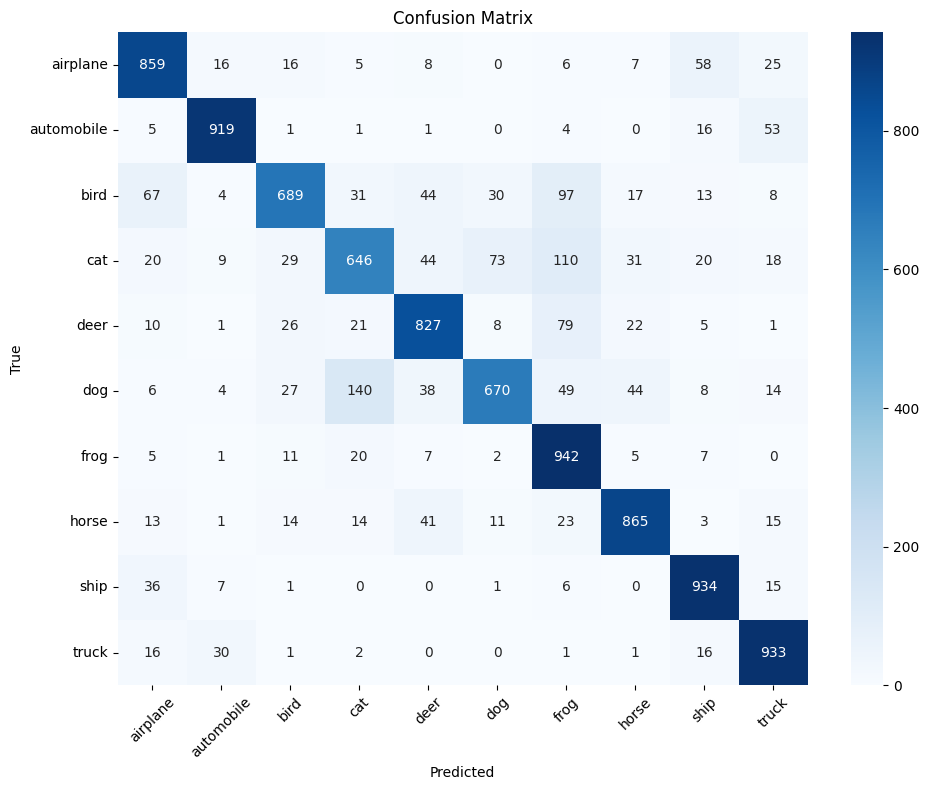

In [ ]:

cm = confusion_matrix(y_true_classes, y_pred_classes) # from sklearn.metrics

plt.figure(figsize=(10, 8))     # 10 inches wide and 8 inches tall
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', # annot=True displays the values in each cell
            xticklabels=class_names, yticklabels=class_names)  # fmt='d' formats to decimal integers
plt.xlabel('Predicted')                                        # cmap='Blues' gradient colormap for shading
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45) # Rotates x-axis labels by 45 degrees for better readability
plt.tight_layout() # Adjusts padding and layout so nothings cuts off(labels, titles)
plt.show()

# # | Issue                                 | Symptom in Matrix                | Fix                                    |
# | ------------------------------------- | -------------------------------- | -------------------------------------- |
# | Underfitting                          | Low values everywhere            | Train longer, bigger model             |
# | Overfitting                           | High train acc, low test acc     | Use dropout, data aug, reduce model    |
# | Class confusion (e.g. "cat" vs "dog") | Off-diagonal values between pair | Add more examples, use class weights   |
# | Bias toward one class                 | One column dominates             | Balance classes, fix architecture      |
# | Misaligned labels                     | Random confusion                 | Check label encoding and loss function |


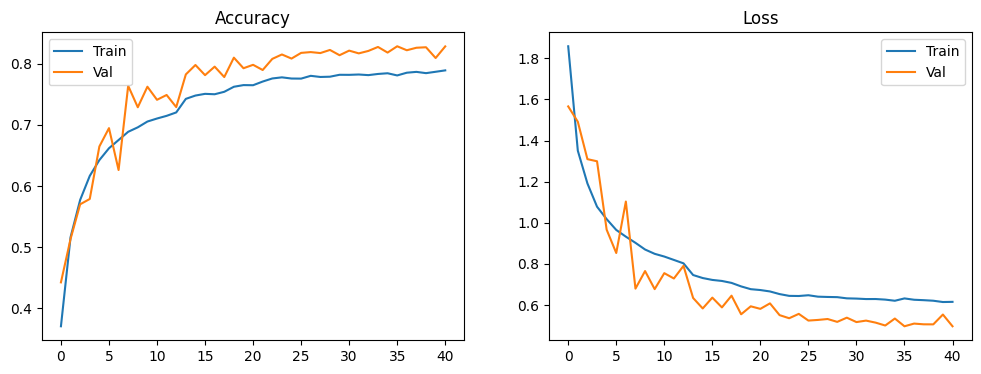

In [ ]:

plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1) # 1 row, 2 columns, 1st subplot
plt.plot(history.history['accuracy'], label='Train') # history.history returned by model.fit() that stores metrics
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2) # 1 row, 2 columns, 2nd subplot
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()

plt.show()

# These plots help answer:
# Is the model learning well?
# Did I overfit or underfit?
# When should I stop training (early stopping)?

In [9]:

def predict_image(image): # Takes an image as input(as NumPy array) and returns predicted class label, confidence, and full prediction vector
    if image.shape != (32, 32, 3):
        image = cv2.resize(image, (32, 32))
    img = image.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0) # Adds batch dimension, making it shape (1, 32, 32, 3), axis=0 means adding a new dimension at the start
    # This is necessary because the model expects input in batches, even if it's just one image
    preds = model.predict(img, verbose=0)[0] # Makes the prediction using trained CNN model. Verbose=0 means no output during prediction
    # [0] : extracts the prediction from the batch (returns a 10-element vector of class probabilities).
    top_idx = np.argmax(preds) # Get the index of the class with the highest probability
    return class_names[top_idx], preds[top_idx], preds  # Returns the predicted class label, confidence, and full prediction vector

import time
# Function to capture webcam feed and make predictions in real-time

def webcam_prediction():
    cap = cv2.VideoCapture(0) # Opens the default webcam (0 is usually the default camera)
    if not cap.isOpened():
        print("Webcam not accessible")
        return

    prev_time = time.time()  # Initialize time for FPS calculation

    while True:
        start_time = time.time()

        ret, frame = cap.read() # Reads a frame from the webcam
        # ret: boolean indicating if frame read successfully, frame is the actual image
        if not ret:
            break

        h, w = frame.shape[:2] # [:2] extracts the first two dimensions (height and width) of the frame shape
        center = frame[h//4:h//4*3, w//4:w//4*3] # from 1/4 to 3/4 of height and width
        label, conf, full_pred = predict_image(center) 

        cv2.rectangle(frame, (w//4, h//4), (w//4*3, h//4*3), (0,255,0), 2)  # Draws a rectangle around the center region of the frame
        # (0,255,0) is the color in BGR format (green), 2 is the thickness of the rectangle
        cv2.putText(frame, f"{label} ({conf:.2%})", (10, 30),  # Position of the text in the frame, conf:.2% formats the confidence as a percentage
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)  # Adds the predicted label and confidence to the frame

        # Calculate and display FPS
        end_time = time.time()
        fps = 1 / (end_time - start_time)
        cv2.putText(frame, f"FPS: {fps:.2f}", (10, 70),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)


        cv2.imshow('CIFAR-10 Prediction', frame) # Display the frame with predictions

        if cv2.waitKey(1) & 0xFF == ord('q'):   # Waits for 1ms for 'q' key to be pressed to exit the loop, 0xFF ensures compatibility across platforms
            break

    cap.release()   
    cv2.destroyAllWindows() # Release the webcam and close all OpenCV windows


In [11]:
# from IPython.display import display
# import ipywidgets as widgets
# from PIL import Image

# upload_btn = widgets.FileUpload(accept='.jpg,.png,.jpeg', multiple=False)
# display(upload_btn)

In [12]:
# import io



# def predict_uploaded_image(upload_widget):
#     if not upload_widget.value:
#         print("No file uploaded.")
#         return

#     # Access the uploaded file from the tuple
#     uploaded_file = upload_widget.value[0]  # first file
#     content = uploaded_file.content

#     img = Image.open(io.BytesIO(content)).convert('RGB')
#     img = img.resize((32, 32))
    
#     img_array = np.array(img).astype('float32') / 255.0
#     img_array = np.expand_dims(img_array, axis=0)

#     prediction = model.predict(img_array, verbose=0)[0]
#     predicted_label = class_names[np.argmax(prediction)]
    
#     plt.imshow(img)
#     plt.title(f"Prediction: {predicted_label} ({np.max(prediction):.2%})")
#     plt.axis('off')
#     plt.show()

# predict_uploaded_image(upload_btn)


In [10]:

#Run this cell to start webcam prediction (press 'q' to quit)
webcam_prediction()


In [ ]:

# Save model
#model.save("cifar10_modelf.h5")
model.save('cifar10_model.keras')



In [8]:

# Load model
#model = keras.models.load_model("cifar10_model.h5")
model = keras.models.load_model("cifar10_model.keras")
